In [12]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import emcee
from scipy.stats import uniform
from emcee.moves import GaussianMove
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import joblib
import os

In [13]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

In [14]:
def log_prior(theta,kernelname):
    ### The periodicity parameter in ExpSineSquared Kernel is much bigger therefore had to change prior to account for this
    if (kernelname == 'ExpSineSquared'):
        return uniform(loc=0.01,scale = 4.99).logpdf(theta[0])+uniform(loc=0.01,scale = 4.99).logpdf(theta[1])+uniform(loc=0.01,scale = 20).logpdf(theta[2])
    else:
        return np.sum(uniform(loc=0.01, scale=4.99).logpdf(theta))

In [15]:
def log_posterior(theta,gpr,kernelname):

    ### get rid before putting through log
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():  
        return -np.inf

    real_theta = np.exp(theta)

    lp = log_prior(real_theta,kernelname)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr.log_marginal_likelihood(theta)


    if not np.isfinite(ll):  
        return -np.inf

    return lp + ll

In [16]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)  
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
alpha = 1
periodicity = 2
gamma = 1


Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu)
Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle)
ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=bounds_lsingle)
Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, metric='laplacian')
RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)

kernel_list = [Radkernel, ExpSinekernel, Laplacekernel, RBFkernel,Matkernel]
kernel_names = ['RationalQuadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matern']
model_types = ["LLpointestimate","MCMC_mean","MCMC_peak"]
dimensions = [3,3,2,5,5]
dimensionnames = [['sigma','alpha','l'],['sigma','l','periodicity'],['sigma','gamma'],['sigma','l1','l2','l3','l4'],['sigma','l1','l2','l3','l4']]
parammult = [[0.5,1,0.5],[0.1,0.1,1],[1,1],[1,2,2,2,2],[1,2,2,2,2]]

### Running MCMC for each kernel then saving 4 different GPR's 
- Saving the Point estimate which is the starting point for MCMC'ing
- Saving the MCMC mean parameters gpr
- Saving the MCMC peak parameters gpr
- Saving the chain made from the MCMC samples so easier to average later

In [17]:
rmse = []
mae = []
r2 = []
adjustedr2 = []
fom = []
pearsoncoeff = []

base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels'

for kernelindex in tqdm(list(range(len(kernel_list))),total = len(kernel_list)):
    kernel_name = kernel_names[kernelindex]
    #### Getting the point estimate, we take this as the starting point for MCMC
    gpr = GaussianProcessRegressor(kernel=kernel_list[kernelindex], alpha=E_train**2,normalize_y=True, n_restarts_optimizer=30,random_state=42)
    gpr.fit(X_train, D_train)

    #####   Saving the model 
    kernel_dir = os.path.join(base_dir, kernel_name)  
    model_filename = os.path.join(kernel_dir, f'GPR_{kernel_name}_{model_types[0]}.joblib')
    joblib.dump(gpr, model_filename)
    print(f"Model saved at: {model_filename}")


    Dfit, Dstd = gpr.predict(X1, return_std=True)
    Dtestfit,Dteststd = gpr.predict(X1_test, return_std=True)
    params = []
    for j in range(dimensions[kernelindex]):
        params.append(np.exp(gpr.kernel_.theta[j]))
    print(f"Point estimates with kernel {kernel_names[kernelindex]} = {params}")

    rmse.append(np.sqrt(mean_squared_error(D1_test, Dtestfit)))
    mae.append(mean_absolute_error(D1_test, Dtestfit))
    r2.append(r2_score(D1_test, Dtestfit))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - Dtestfit)/Dteststd))
    corr, p_value = pearsonr(D1_test.ravel(), Dtestfit.ravel())
    pearsoncoeff.append(corr)

    #### MCMC sampling with starting point decided by above and moved by twice these values to make sure we sample a broad space
    np.random.seed(42)
    ndim = dimensions[kernelindex]
    nwalkers = ndim*4 
    mean = np.array(params)
    cov_matrix = np.diag(2*np.array(params))
    ### Where we start sampling. I take the absolute value here because I want my parameters to be positive
    initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers)) 
    cov = 1e-2
    ### try cov = 1e-2
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args= (gpr,kernel_names[kernelindex]),moves = GaussianMove(cov=cov))
    nsteps = 500
    samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)

    acceptance_fraction = sampler.acceptance_fraction
    burnin = 100
    thin = 15
    print(f"acceptance fraction = {acceptance_fraction.mean()}")

    flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

    #### Saving these flat samples
    kernel_dir = os.path.join(base_dir, kernel_name)
    samples_filename = os.path.join(kernel_dir, f'MCMC_HyperparameterSamples_{kernel_name}.npz')
    np.savez(samples_filename, samples=flat_samples)
    print(f"Saved MCMC samples at: {samples_filename}")

    #### Now we have the MCMC samples. We find the peak and mean values of the parameters from the samples

    ##We have to make a gaussian kde to get the densities to then get the peak
    peak_values = []
    for i in range(ndim):
        samples_i = flat_samples[:, i]
        kde = gaussian_kde(samples_i)  
        x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
        density = kde(x_range)
        peak = x_range[np.argmax(density)]
        peak_values.append(peak)

    print(f"Peak Params after MCMC with kernel {kernel_names[kernelindex]} = {peak_values}")
    
    mean_values = np.mean(flat_samples, axis=0)

    print(f"Mean Params after MCMC with kernel {kernel_names[kernelindex]} = {mean_values}")

    #### GPR on mean parameter values

    kernel = gpr.kernel_.clone_with_theta(np.log(mean_values))
    gpr1 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
    gpr1.fit(X_train, D_train)
    Dfit1, Dstd1 = gpr1.predict(X1, return_std=True)
    Dfit1_test, Dstd1_test = gpr1.predict(X1_test, return_std=True)

    rmse.append(np.sqrt(mean_squared_error(D1_test, Dfit1_test)))
    mae.append(mean_absolute_error(D1_test, Dfit1_test))
    r2.append(r2_score(D1_test, Dfit1_test))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - Dfit1_test)/Dstd1_test))
    corr, p_value = pearsonr(D1_test.ravel(), Dfit1_test.ravel())
    pearsoncoeff.append(corr)


    #####   Saving the model
    kernel_dir = os.path.join(base_dir, kernel_name)  
    model_filename = os.path.join(kernel_dir, f'GPR_{kernel_name}_{model_types[1]}.joblib')
    joblib.dump(gpr1, model_filename)
    print(f"Model saved at: {model_filename}")



    ### GPR on peak parameter values
    kernel = gpr.kernel_.clone_with_theta(np.log(np.array(peak_values)))
    gpr2 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
    gpr2.fit(X_train, D_train)
    Dfit2, Dstd2 = gpr2.predict(X1, return_std=True)
    Dfit2_test,Dstd2_test = gpr2.predict(X1_test,return_std=True)

    rmse.append(np.sqrt(mean_squared_error(D1_test, Dfit2_test)))
    mae.append(mean_absolute_error(D1_test, Dfit2_test))
    r2.append(r2_score(D1_test, Dfit2_test))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - Dfit2_test)/Dstd2_test))
    corr, p_value = pearsonr(D1_test.ravel(), Dfit2_test.ravel())
    pearsoncoeff.append(corr)

    #####   Saving the model
    kernel_dir = os.path.join(base_dir, kernel_name)  
    model_filename = os.path.join(kernel_dir, f'GPR_{kernel_name}_{model_types[2]}.joblib')
    joblib.dump(gpr2, model_filename)
    print(f"Model saved at: {model_filename}")
    

    #### Marginalising over all the samples
    S = len(flat_samples)
    pred_means = np.zeros((S, len(X1)))
    pred_vars = np.zeros((S, len(X1)))
    pred_means_test = np.zeros((S, len(X1_test)))
    pred_vars_test = np.zeros((S, len(X1_test)))

    # Iterate over posterior samples of hyperparameters with a progress bar
    for s in tqdm(range(S), desc="Running GP Predictions", unit="sample"):
        theta_s = flat_samples[s]  # Get one sample from posterior
        kernel = gpr.kernel_.clone_with_theta(np.log(theta_s))  # Set kernel with sampled hyperparameters
        gp = GaussianProcessRegressor(kernel=kernel,alpha =E_train**2, optimizer= None)  
        gp.fit(X_train, D_train)  # Fit GP with the sampled hyperparameters
        # Predictive mean and variance for X1
        pred_means[s, :], pred_stds = gp.predict(X1, return_std=True)
        pred_vars[s, :] = pred_stds**2  # Convert std deviation to variance
        pred_means_test[s, :], pred_stds_test = gp.predict(X1_test, return_std=True)
        pred_vars_test[s, :] = pred_stds_test**2
    final_mean = np.mean(pred_means, axis=0)
    final_variance = np.mean(pred_vars + pred_means**2, axis=0) - final_mean**2
    final_std = np.sqrt(final_variance)
    test_mean = np.mean(pred_means_test, axis=0)
    test_variance = np.mean(pred_vars_test + pred_means_test**2, axis=0) - test_mean**2
    test_std = np.sqrt(test_variance)

    rmse.append(np.sqrt(mean_squared_error(D1_test, test_mean)))
    mae.append(mean_absolute_error(D1_test, test_mean))
    r2.append(r2_score(D1_test, test_mean))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - test_mean)/test_std))
    corr, p_value = pearsonr(D1_test.ravel(), test_mean.ravel())
    pearsoncoeff.append(corr)

  0%|          | 0/5 [00:00<?, ?it/s]

Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RationalQuadratic\GPR_RationalQuadratic_LLpointestimate.joblib
Point estimates with kernel RationalQuadratic = [4.323481990573891, 0.3082081095253023, 1.786510881078687]


c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\mh.py:58: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = new_log_probs - state.log_prob + factors
100%|██████████| 500/500 [01:59<00:00,  4.19it/s]


acceptance fraction = 0.3086666666666667
Saved MCMC samples at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RationalQuadratic\MCMC_HyperparameterSamples_RationalQuadratic.npz
Peak Params after MCMC with kernel RationalQuadratic = [2.8310076610308172, 0.14691984784587514, 1.4076814171185563]
Mean Params after MCMC with kernel RationalQuadratic = [4.66686294 0.48828229 1.82670874]
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RationalQuadratic\GPR_RationalQuadratic_MCMC_mean.joblib
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RationalQuadratic\GPR_RationalQuadratic_MCMC_peak.joblib


 20%|██        | 1/5 [03:18<13:15, 198.85s/it]

Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\ExpSineSquared\GPR_ExpSineSquared_LLpointestimate.joblib
Point estimates with kernel ExpSineSquared = [1.1542629387131134, 0.47239740760157045, 11.28204572305942]


100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


acceptance fraction = 0.4306666666666667
Saved MCMC samples at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\ExpSineSquared\MCMC_HyperparameterSamples_ExpSineSquared.npz
Peak Params after MCMC with kernel ExpSineSquared = [1.6923766512821756, 0.40361099296564273, 8.954363913592372]
Mean Params after MCMC with kernel ExpSineSquared = [ 2.19033567  0.65702261 11.69499373]
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\ExpSineSquared\GPR_ExpSineSquared_MCMC_mean.joblib
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\ExpSineSquared\GPR_ExpSineSquared_MCMC_peak.joblib


 40%|████      | 2/5 [08:49<13:48, 276.33s/it]c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Laplacian\GPR_Laplacian_LLpointestimate.joblib
Point estimates with kernel Laplacian = [1.2533539111996768, 0.2502837702930708]


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


acceptance fraction = 0.27475000000000005
Saved MCMC samples at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Laplacian\MCMC_HyperparameterSamples_Laplacian.npz
Peak Params after MCMC with kernel Laplacian = [1.416417737187312, 0.2168855223638767]
Mean Params after MCMC with kernel Laplacian = [1.49896905 0.24186815]
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Laplacian\GPR_Laplacian_MCMC_mean.joblib
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Laplacian\GPR_Laplacian_MCMC_peak.joblib


 60%|██████    | 3/5 [11:27<07:24, 222.46s/it]

Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RBF\GPR_RBF_LLpointestimate.joblib
Point estimates with kernel RBF = [0.6009690454941182, 0.20756257886465224, 0.762790921637476, 0.6980066705615466, 2.0129349667438974]


100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


acceptance fraction = 0.22759999999999997
Saved MCMC samples at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RBF\MCMC_HyperparameterSamples_RBF.npz
Peak Params after MCMC with kernel RBF = [0.7304798578580254, 0.13370788019179108, 0.7697556216557349, 0.8161484507166193, 2.195832160630016]
Mean Params after MCMC with kernel RBF = [0.89710645 0.20087551 0.67841053 1.11467442 2.58251563]
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RBF\GPR_RBF_MCMC_mean.joblib
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\RBF\GPR_RBF_MCMC_peak.joblib


 80%|████████  | 4/5 [16:33<04:15, 255.38s/it]

Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Matern\GPR_Matern_LLpointestimate.joblib
Point estimates with kernel Matern = [0.8472284268279076, 0.28242888703172475, 0.7979297800004849, 1.4668235969874241, 4.208967727852938]


c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\mh.py:58: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = new_log_probs - state.log_prob + factors
100%|██████████| 500/500 [17:51<00:00,  2.14s/it]


acceptance fraction = 0.2682
Saved MCMC samples at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Matern\MCMC_HyperparameterSamples_Matern.npz
Peak Params after MCMC with kernel Matern = [0.8653293538730965, 0.3310374938928339, 0.5093797424163989, 1.5864864676241477, 4.337868874887979]
Mean Params after MCMC with kernel Matern = [1.08110315 0.54307569 0.96509934 1.79716923 5.01561198]
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Matern\GPR_Matern_MCMC_mean.joblib
Model saved at: C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\TrainedModels\Matern\GPR_Matern_MCMC_peak.joblib


100%|██████████| 5/5 [42:13<00:00, 506.75s/it]


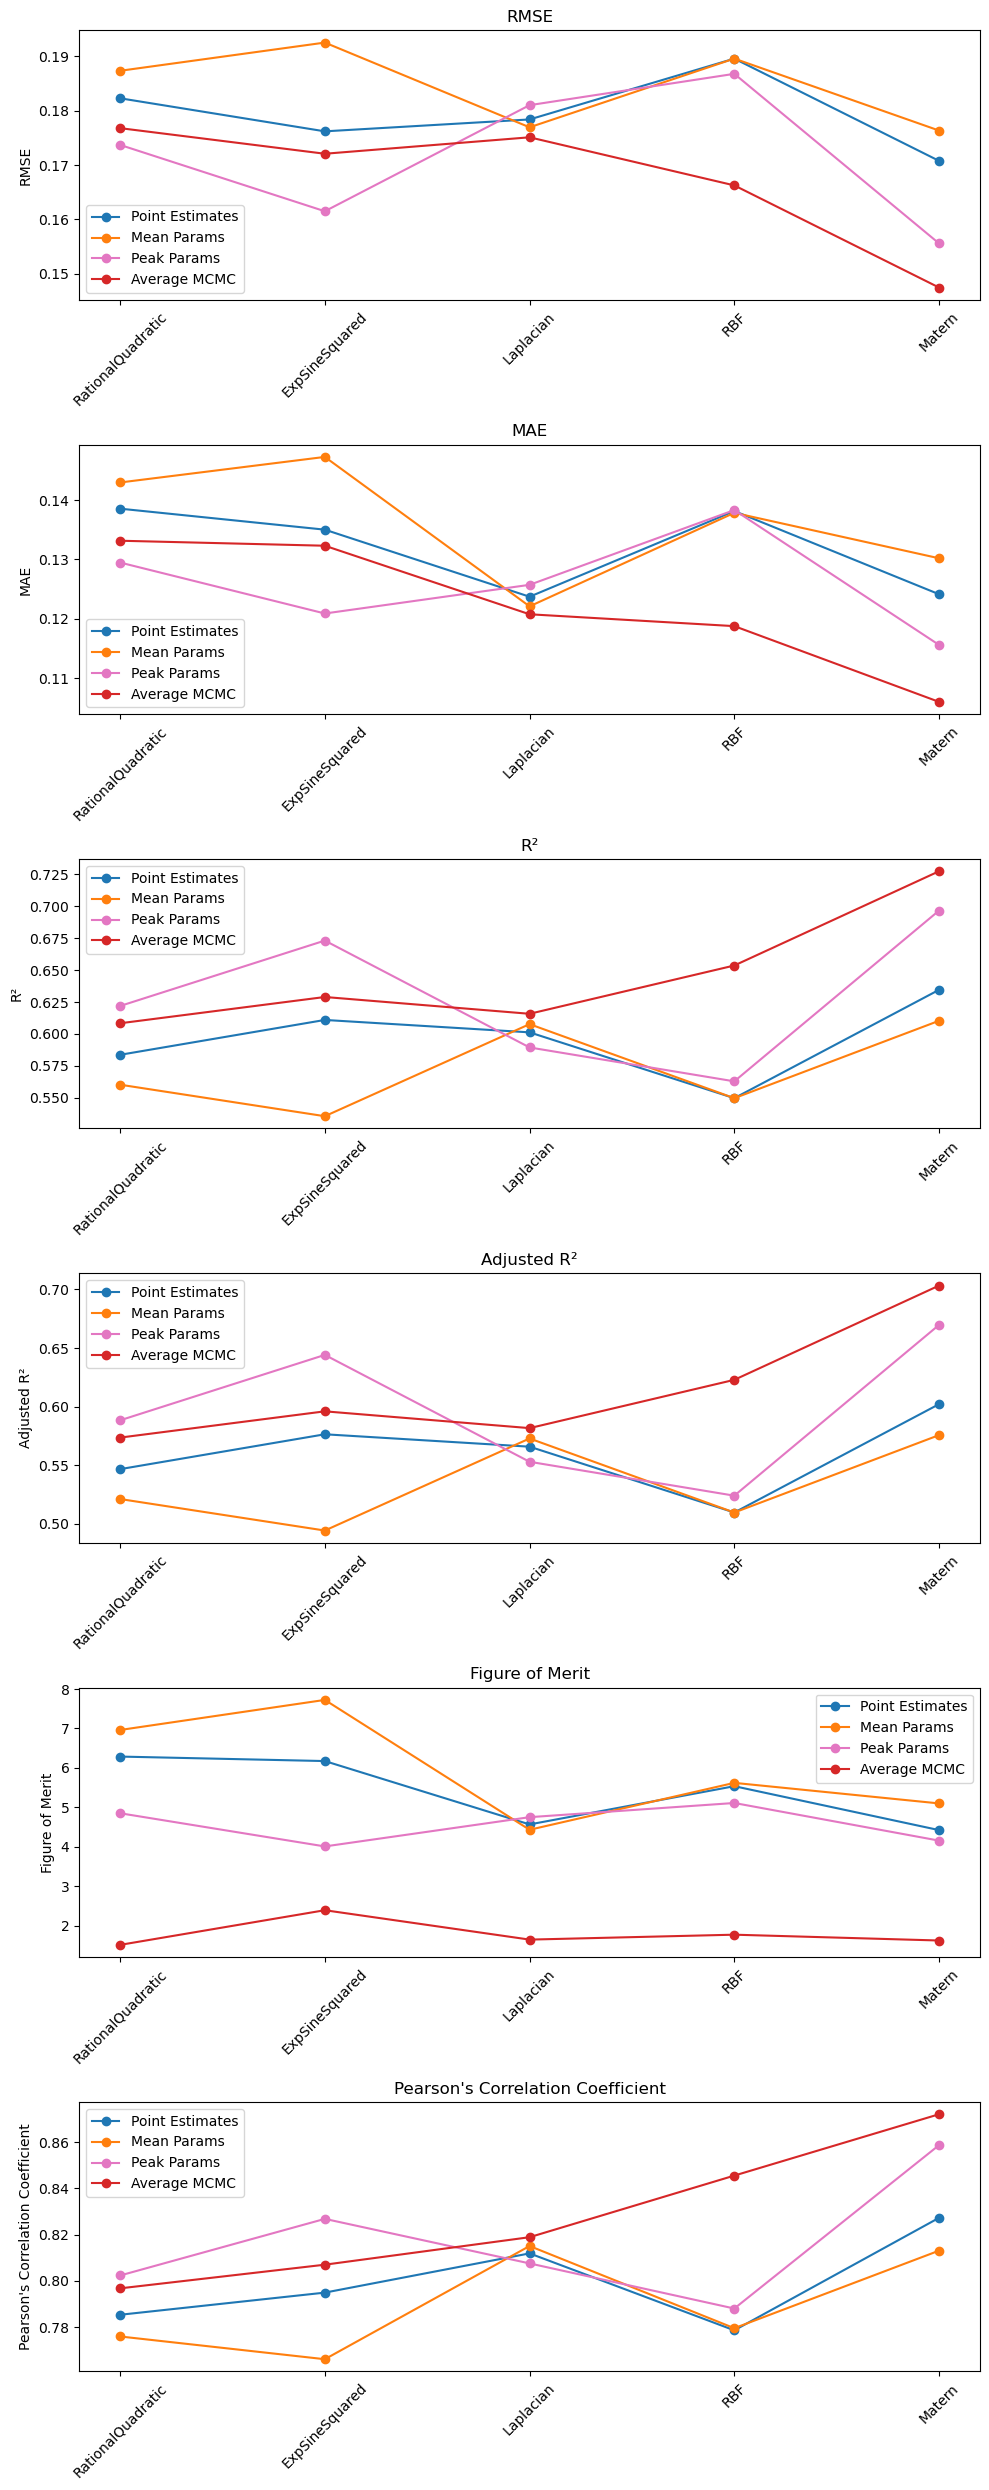

In [20]:
metrics = np.array([rmse,mae,r2,adjustedr2,fom,pearsoncoeff])
metric_names = ["RMSE", "MAE", "R²", "Adjusted R²", "Figure of Merit","Pearson's Correlation Coefficient"]
modelnames = ["Point Estimates","Mean Params","Peak Params","Average MCMC"]
pointestimatemetrics = metrics[:,0::4]
meanparamsmetrics = metrics[:,1::4]
peakparamsmetrics = metrics[:,2::4]
averagemcmcmetrics = metrics[:,3::4]

colors = ['#1f77b4', '#ff7f0e','#e377c2','#d62728']

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,25))

for i in range(6):
    axes[i].plot(range(len(kernel_names)),pointestimatemetrics[i,:],'-o',label=modelnames[0],color=colors[0])
    axes[i].plot(range(len(kernel_names)),meanparamsmetrics[i,:],'-o',label=modelnames[1],color=colors[1])
    axes[i].plot(range(len(kernel_names)),peakparamsmetrics[i,:],'-o',label=modelnames[2],color=colors[2])
    axes[i].plot(range(len(kernel_names)),averagemcmcmetrics[i,:],'-o',label=modelnames[3],color=colors[3])
    axes[i].set_title(metric_names[i])
    axes[i].legend(loc='best')
    axes[i].set_xticks(range(len(kernel_list)))
    axes[i].set_xticklabels(kernel_names, rotation=45)
    axes[i].set_title(metric_names[i])
    axes[i].set_ylabel(metric_names[i])
plt.tight_layout()
plt.show()

### Saving the Metrics for each Model helping to compare different Models later

In [21]:
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\pointestimates.csv", pointestimatemetrics, delimiter=",")
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\meanparams.csv", meanparamsmetrics, delimiter=",")
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\peakparams.csv", peakparamsmetrics, delimiter=",")
np.savetxt(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\MCMCaveraged.csv", averagemcmcmetrics, delimiter=",")